NN transfers info via hidden layers while RNN uses sequential data. RNNs depend on past calculations and LSTM is good for order dependence in predictions. We'll cover an LSTM autoencoder in Python with Keras to compress and decode S&P index closing prices while maintaining its structure.

In [39]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train shape:',train.shape,'Test Shape:',test.shape)

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

def create_dataset(X, y, time_steps=1):
    X1, y1 = [], []
    for i in range(len(X) - time_steps):
        t = X.iloc[i:(i + time_steps)].values
        X1.append(t)
        y1.append(y.iloc[i + time_steps])
    return np.array(X1), np.array(y1)

TIME_STEPS = 30
X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)
print(X_train.shape)

Train shape: (6553, 1) Test Shape: (1639, 1)


<ipython-input-39-ac54122304b7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-39-ac54122304b7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


(6523, 30, 1)


# **Creating an LSTM Autoencoder Network**

Architecture replicates input, dropout reduces overfitting. RepeatVector repeats n times, while TimeDistributed creates output vectors from previous layers.

In [2]:
# dimension_embedding = 30

model = keras.Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(RepeatVector(n=X_train.shape[1]))

# model.add(LSTM(units=dimension_embedding))
# model.add(RepeatVector(n=X_train.shape[1]))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

In [3]:
callback_earlystopping = EarlyStopping(monitor='val_loss', patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=30, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, shuffle=False, callbacks=[callback_earlystopping, reduce_lr])

Epoch 1/1000
164/164 [==============================] - 16s 25ms/step - loss: 0.2112 - val_loss: 0.1702 - lr: 0.0010
Epoch 2/1000
164/164 [==============================] - 2s 15ms/step - loss: 0.1383 - val_loss: 0.1032 - lr: 0.0010
Epoch 3/1000
164/164 [==============================] - 4s 22ms/step - loss: 0.1121 - val_loss: 0.0998 - lr: 0.0010
Epoch 4/1000
164/164 [==============================] - 2s 13ms/step - loss: 0.1229 - val_loss: 0.0970 - lr: 0.0010
Epoch 5/1000
164/164 [==============================] - 1s 8ms/step - loss: 0.1201 - val_loss: 0.0894 - lr: 0.0010
Epoch 6/1000
164/164 [==============================] - 1s 8ms/step - loss: 0.1189 - val_loss: 0.0871 - lr: 0.0010
Epoch 7/1000
164/164 [==============================] - 1s 8ms/step - loss: 0.1319 - val_loss: 0.0843 - lr: 0.0010
Epoch 8/1000
164/164 [==============================] - 1s 8ms/step - loss: 0.1581 - val_loss: 0.0998 - lr: 0.0010
Epoch 9/1000
164/164 [==============================] - 1s 8ms/step - loss:

# **Evaluation**

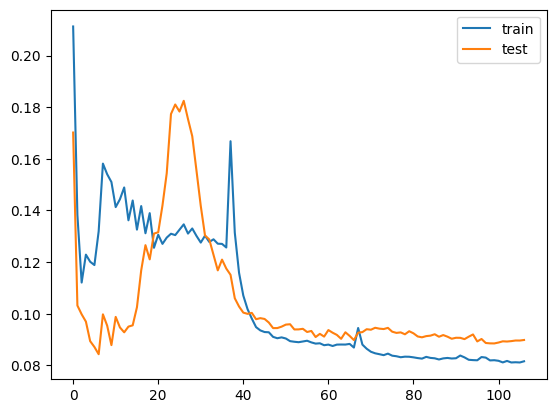

In [4]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [5]:
pred = model.predict(X_test, verbose=0)
mape = np.mean(list(mean_absolute_percentage_error(X_test[i],pred[i]) for i in range(len(X_test))))
mae = np.mean(list(mean_absolute_error(X_test[i],pred[i]) for i in range(len(X_test))))
print('MAPE =',mape)
print('MAE =',mae)

MAPE = 0.17623867396867107
MAE = 0.5592619609044203


# **Plotting the MAPE**

In [26]:
# Testing set
pred_train = model.predict(X_train)
train_mape = [mean_absolute_percentage_error(pred_train[i],X_train[i]) for i in range(len(pred_train))]
train_error = pd.DataFrame({'Reconstruction_error': train_mape, 'True_class': y_train})
train_error

204/204 [==============================] - 1s 5ms/step


,Reconstruction_error,True_class
0,0.059441,-1.497401
1,0.061034,-1.491745
2,0.063762,-1.485298
3,0.066701,-1.491745
4,0.062107,-1.485850
...,...,...
6518,0.080101,0.904583
6519,0.072562,0.870288
6520,0.085680,0.956445
6521,0.060213,0.962244


In [27]:
train_error.describe()

,Reconstruction_error,True_class
count,6523.000000,6523.000000
mean,0.967676,0.006970
std,38.616006,0.997066
min,0.004018,-1.497401
25%,0.025783,-1.020760
50%,0.049704,0.198530
75%,0.112817,0.883865
max,3067.103299,1.732573


# **Determine the threshold to optimize F1 score**

In [28]:
plot_train_error = train_error
plot_train_error[plot_train_error['True_class']<0] = 0
plot_train_error[plot_train_error['True_class']>0] = 1

In [29]:
# Plotting the precision recall curve.
precision, recall, threshold = precision_recall_curve(plot_train_error.True_class, train_error.Reconstruction_error)
f1_score = 2 * precision * recall / (precision + recall)
average_precision = average_precision_score(plot_train_error.True_class, train_error.Reconstruction_error)

# Choosing the threshold to maximize the F1 score
max_f1 = f1_score[f1_score == max(f1_score)]
best_threshold = threshold[np.argmax(f1_score)]

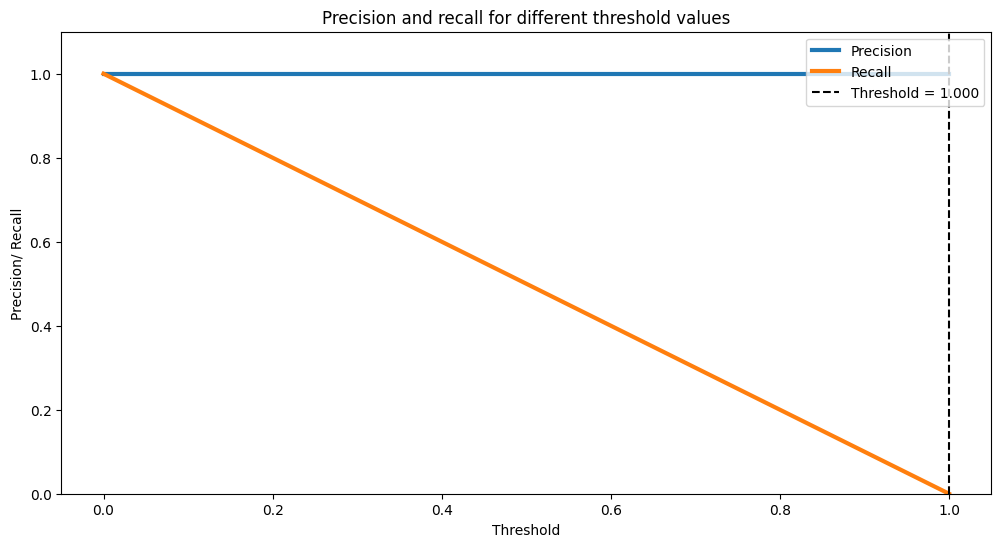

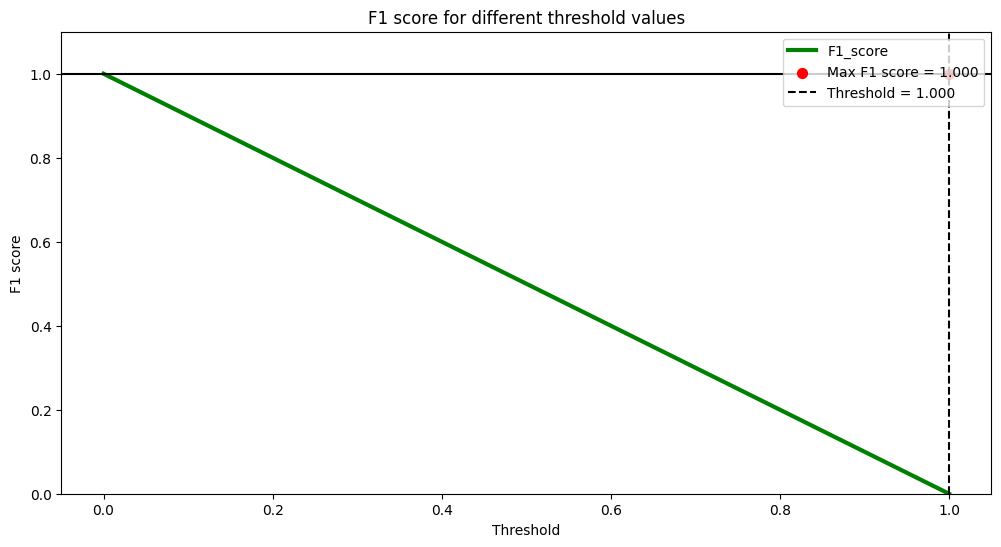

Best threshold = 1.000000
Max F1 score = 1.000000


In [30]:
## Precision, Recall curve 
plt.figure(figsize = (12, 6))
plt.plot(threshold, precision[1: ], label = "Precision", linewidth = 3)
plt.plot(threshold, recall[1: ], label ="Recall", linewidth = 3)
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall')
plt.title('Precision and recall for different threshold values')
plt.legend(loc = 'upper right')

## F1 score curve
plt.figure(figsize = (12, 6))
plt.plot(threshold, f1_score[1: ], label = "F1_score", linewidth = 3, color = 'green')
plt.scatter(best_threshold, max_f1, label = 'Max F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.axhline(max_f1, color = 'black', ls = '-')
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 score for different threshold values')
plt.legend(loc = 'upper right')

plt.show()
print('Best threshold = %f' % (best_threshold))
print('Max F1 score = %f' % (max_f1))

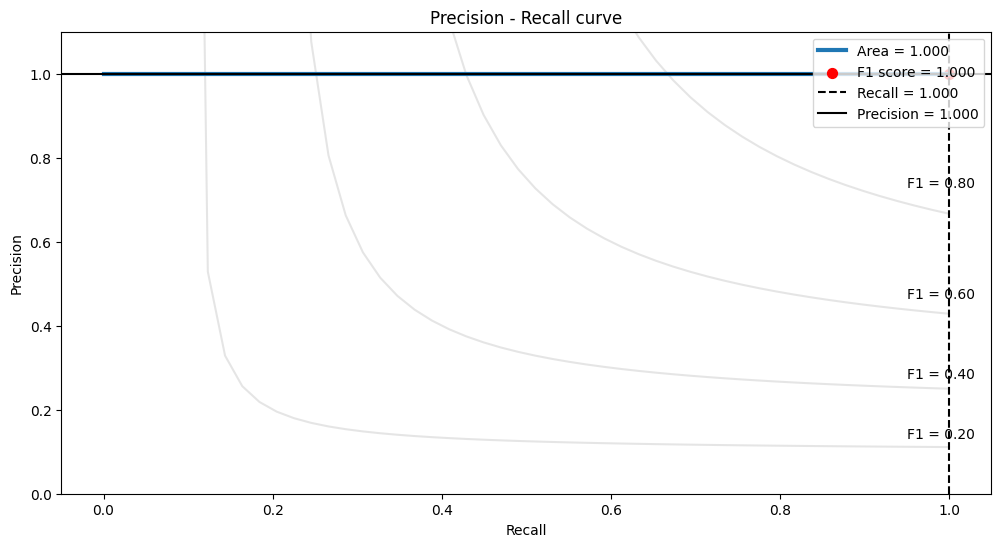

In [31]:
## Recall - Precision curve
plt.figure(figsize = (12, 6))
f_scores = np.linspace(0.2, 0.8, num = 4)

for f_score in f_scores:
    x = np.linspace(0.001, 1)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color = 'gray', alpha = 0.2)
    plt.annotate('F1 = {0:0.2f}'.format(f_score), xy = (0.95, y[45] + 0.02))

plt.plot(recall[1: ], precision[1: ], label = 'Area = %0.3f' % (average_precision), linewidth = 3)
plt.scatter(recall[f1_score == max_f1], precision[f1_score == max_f1], label = 'F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(recall[f1_score == max_f1], color = 'black', ls = '--', label = 'Recall = %0.3f' % (recall[f1_score == max_f1]))
plt.axhline(precision[f1_score == max_f1], color = 'black', ls = '-', label = 'Precision = %0.3f' % (precision[f1_score == max_f1]))
plt.ylim(0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall curve')
plt.legend(loc = 'upper right')

plt.show()

# **AutoEncoder Classifier**

In [32]:
# Create AE predictor
def AE_predictor(X, model, threshold):
    X_valid = model.predict(X)
    mape = [mean_absolute_percentage_error(X_valid[i],X[i]) for i in range(len(pred))]
    y = np.zeros(shape = len(mape))
    y[mape > threshold] = 1
    return y

In [33]:
y_test_testttt = np.where(y_test>0,0,1)

51/51 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1609

    accuracy                           1.00      1609
   macro avg       1.00      1.00      1.00      1609
weighted avg       1.00      1.00      1.00      1609



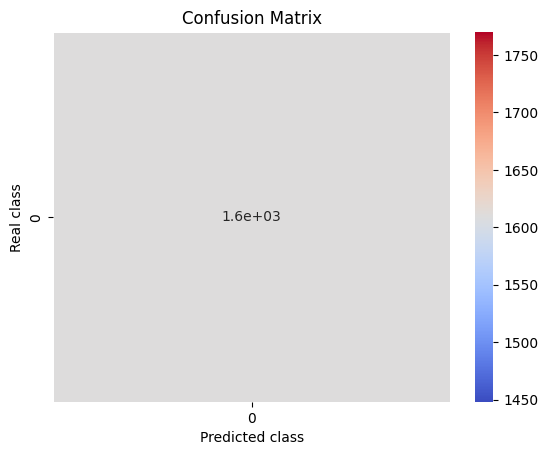

In [36]:
y_pred = AE_predictor(X = X_test, model = model, threshold = best_threshold)
cm = confusion_matrix(y_test_testttt, y_pred)
print(classification_report(y_test_testttt, y_pred))

plt.figure()
sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.show()